# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

**Последовательность выполнения проекта**

* Загрузка файлов, их изучение и подготовка к дальнейшему анализу
* Предобработка данных (обработка пропусков, изменение типов данных, обработка артефактов)
* Расчеты и добавление в общую таблицу:
    1. Цены квадратного метра;
    2. Дня недели, месяца и года публикации объявления;
    3. Этажа квартиры; варианты — первый, последний, другой;
    4. Соотношения жилой и общей площади, а также отношения площади кухни к общей.
* Проведение исследовательского анализа данных:
    1. Изучение следующих параметров квартир: площадь, цена, число комнат, высота потолков.
    2. Изучение времени продажи квартиры.
    3. Обработка аномальных значений.
    4. Определение факторов больше всего влияющих на стоимость квартиры.
    5. Выбрать 10 населённых пунктов с наибольшим числом объявлений. Посчитать среднюю цену квадратного метра в этих населённых пунктах. Выделить населённые пункты с самой высокой и низкой стоимостью жилья.
    6. Выяснить, какая область Петербурга входит в центр, для этого расчитать среднюю цену для каждого километра. Построить график: он должен показывать, как цена зависит от удалённости от центра. Определить границу, где график сильно меняется, — это и будет центральная зона.
    7. Выделить сегмент квартир в центре. Проанализировать эту территорию и изучить следующие параметры: площадь, цена, число комнат, высота потолков. Также выделить факторы, которые сильнее всего влияют на стоимость квартиры.
* Подведение выводов по исследованию

## Изучение данных из файла

In [1]:
#импорт нужных библиотек
import pandas as pd
from IPython.display import display
import warnings
import datetime
import matplotlib.pyplot as plt

#отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
#сохраним данные в нашу переменную df и укажем сепаратор для исходных данных
df = pd.read_csv('D:/Datasets/real_estate_data.csv', sep='\t')
display(df.head()) #посмотрим первые 5 столбцов

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Опишем наши данные методом `describe()`

In [3]:
df.describe().T 

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


Можем сразу заметить пропуски во многих колонках, кроме того в некоторых столбцах сразу заметны значительные средние отклонения, что говорит об аномальных значениях в этих столбцах. В дальнейшем подробнее ознакомимся с этими аномалиями. 

In [4]:
df.info() #общая информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Всего в таблице 22 столбца.

2 столбца типа `bool`, 14 столбцов типа `float64`, 3 столбца типа `int64`, 3 столбца типа `object`

Согласно документации к данным:

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах(м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

В части колонок присутствуют пропуски, так как можем наблюдать их неодинаковую длину. Столбец `is_apartment` не является типом bool. Так же формат даты некорректен. В будущем это исправим

In [5]:
df.columns #выведем названия колонок

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Часть колонок не соответствуют змеиному стилю, в будущем так же это исправим.

### Выводы

В данных присутствуют пропуски, часть колонок не соответствуют змеиному стилю, кроме того, некоторые столбцы имеют неправильный тип. В будущих пунктах всё это исправим.

## Предобработка данных

### Стиль заголовков

In [6]:
#исправление стиля заголовков
df = df.rename(columns={'studio': 'is_studio', 
                        'open_plan': 'has_open_plan', 
                        'cityCenters_nearest': 'city_centers_nearest',
                        'parks_around3000': 'parks_around_3000',
                        'ponds_around3000': 'ponds_around_3000'})
df.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'has_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3000', 'parks_nearest', 'ponds_around_3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Изменили названия колонок под змеиный стиль

### Обработка артефактов

In [7]:
#исправление ё на е
df = df.dropna(subset=['locality_name']) #выбросим пропуски из нужного столбца, чтобы наша замена слов сработала
replaced_words = df['locality_name'].str.startswith(('посёлок', 'городской посёлок'))
df.loc[replaced_words, 'locality_name'] = df.loc[replaced_words, 'locality_name'].str.replace('посёлок','поселок')

#исправление названий населённых пунктов для дальнейшего исследования
df['locality_name'] = df['locality_name'].replace('деревня Кудрово', 'Кудрово')
df['locality_name'] = df['locality_name'].replace(['поселок Мурино', 'Мурино'], 'Мурино')

#фильтр для комнат и минимальной стоимости квартир
df = df.query('rooms != 0')
df = df.query('last_price > 100000')

Обработали артефакты названий населённых пунктов и не только

### Обработка пропусков

In [8]:
df.isna().sum() #посмотрим количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9045
floors_total               82
living_area              1884
floor                       0
is_apartment            20698
is_studio                   0
has_open_plan               0
kitchen_area             2072
balcony                 11441
locality_name               0
airports_nearest         5455
city_centers_nearest     5432
parks_around_3000        5431
parks_nearest           15418
ponds_around_3000        5431
ponds_nearest           14436
days_exposition          3166
dtype: int64

Больше всего пропусков присутствует в столбцах `is_apartment`, `parks_nearest`, `ponds_nearest`. В большинстве других столбцов так же присутствуют пропуски. 

Займёмся их обработкой.

Займёмся заполнением пропусков с помощью метода `groupby`, а в некоторых столбцах с помощью традиционных нулей.

Выбросим оставшиеся пропуски в 4-х столбцах, так как их осталось не так много.

In [9]:
#заполнение пропусков с помощью группировки методом groupby по медиане нужного значения
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby(['rooms', 'floors_total', 'locality_name'])['ceiling_height'].transform('median'))
df['kitchen_area'] = df['kitchen_area'].fillna(df.groupby(['rooms', 'floors_total', 'locality_name'])['kitchen_area'].transform('median'))
df['living_area'] = df['living_area'].fillna(df.groupby(['rooms', 'floors_total', 'locality_name'])['living_area'].transform('median'))
df['days_exposition'] = df['days_exposition'].fillna(df.groupby(['rooms', 'floors_total', 'locality_name'])['days_exposition'].transform('median'))
df['ceiling_height'] = df['ceiling_height'].fillna(df.groupby(['rooms', 'floors_total', 'locality_name'])['ceiling_height'].transform('median'))
df = df.query('2.4 <= ceiling_height <= 4') #сразу ставим фильтр для комнат, чтобы отсечь редкие значения

#заполним эти столбцы нулями
df['balcony'] = df['balcony'].fillna(0) #в случае балконов это логично, что нет балкона, если пользователь его не указал
df['is_apartment'] = df['is_apartment'].fillna(0) #заполнение нулями для нашего удобства

#можем себе позволить удалить небольшое количество пропусков в данных для дальнейших вычислений
df = df.dropna(subset=['floors_total'])
df = df.dropna(subset=['living_area'])
df = df.dropna(subset=['kitchen_area'])
df = df.dropna(subset=['days_exposition'])

В случае столбца с расстоянием до центра создадим функцию для заполнения пропусков.

In [10]:
#создадим переменную для будущей функции, в которой сохраним медианное значение расстояния до центра Петербурга
#это необходимо для дальнейшего исследования
spb_city_center_median = df.query('locality_name == "Санкт-Петербург"')['city_centers_nearest'].median()

#создаём функцию для заполнения пропусков в столбце city_centers_distance
#все значения, которые появляются в функции, были взяты с сервиса Яндекс Карты
def na_replace_city_center(row):
    city = row['locality_name']
    center_distance = row['city_centers_nearest']
    
    if center_distance > 0:
        return(center_distance)
    else:
        if city == 'Мурино':
            return(20000)
        elif city == 'Всеволожск':
            return(26000)
        elif city == 'Кудрово':
            return(14000)
        elif city == 'Гатчина':
            return(46000)
        elif city == 'Выборг':
            return(140000)
        elif city == 'деревня Новое Девяткино':
            return(19000)
        elif city == 'Сертолово':
            return(26000)
        elif city == 'Кириши':
            return(160000)
        elif city == 'Сланцы':
            return(180000)
        elif city == 'Волхов':
            return(130000)
        elif city == 'Кингисепп':
            return(130000)
        elif city == 'Тосно':
            return(57000)
        elif city == 'Никольское':
            return(46000)
        elif city == 'Коммунар':
            return(41000)
        elif city == 'Сосновый Бор':
            return(96000)
        elif city == 'Санкт-Петербург':
            return(spb_city_center_median)

#применяем нашу функцию для датафрейма       
df['city_centers_nearest'] = df.apply(na_replace_city_center, axis=1)

df.isna().sum() #проверяем, насколько изменилось количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
is_studio                   0
has_open_plan               0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4660
city_centers_nearest     1726
parks_around_3000        4639
parks_nearest           14440
ponds_around_3000        4639
ponds_nearest           13496
days_exposition             0
dtype: int64

Пропусков стало значительно меньше. Самое главное, что мы разобрались со всеми пропусками в важных для дальнейшего исследования колонках.

### Изменение типов данных

In [11]:
df['is_apartment'] = df['is_apartment'].astype('bool') #тип изначально не является bool, исправим это
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT') #меняем тип объекта на datetime
df['balcony'] = df['balcony'].astype('int32') #чтобы не было нецелочисленных балконов
df['floors_total'] = df['floors_total'].astype('int32') #для дальнейших вычислений
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22341 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          22341 non-null  int64         
 1   last_price            22341 non-null  float64       
 2   total_area            22341 non-null  float64       
 3   first_day_exposition  22341 non-null  datetime64[ns]
 4   rooms                 22341 non-null  int64         
 5   ceiling_height        22341 non-null  float64       
 6   floors_total          22341 non-null  int32         
 7   living_area           22341 non-null  float64       
 8   floor                 22341 non-null  int64         
 9   is_apartment          22341 non-null  bool          
 10  is_studio             22341 non-null  bool          
 11  has_open_plan         22341 non-null  bool          
 12  kitchen_area          22341 non-null  float64       
 13  balcony         

### Обработка дубликатов

In [12]:
df.duplicated().sum()

0

Дубликаты не обнаружены

### Выводы

Мы проделали хорошую работу в разделе предобработки данных:

* Стиль заголовков был приведён к единому змеиному стилю
* Часть артефактов были обработаны
* БОльшая часть пропусков была обработана
* Тип данных в некоторых столбцах был изменён
* Дубликаты обнаружены не были

Проведя этот набор операций мы можем начать работать с нашими набором данных.

## Расчёты и добавление результатов в таблицу

Добавим столбцы с ценой за квадратный метр, а также столбцы, основанные на дате объявления: день недели, месяц, год.

In [13]:
#добавляем столбец с ценой за квадратный метр, затем округляем полученное значение
df['square_meter_price'] = (df['last_price'] / df['total_area']).round(1)

df['weekday'] = df['first_day_exposition'].dt.weekday #добавление столбца с днём недели
df['month'] = df['first_day_exposition'].dt.month #с месяцем
df['year'] = df['first_day_exposition'].dt.year #с годом

Теперь создадим функцию для определения этажа квартиры.

In [14]:
#функция для определения этажа (первый, последний, промежуточный)
#Оставляем в функции числа 1,2,3, так я не смог разобраться, как в дальнейшем сделать корреляцию между строкой и числом
#Соответственно, 3 - это последний этаж, 2 - промежуточный, 1 - первый
def floor_grouped(row):
    floor = row['floor']
    floors_total = row['floors_total']

    if floor == floors_total:
        return('3')
    elif floor in range(2, floors_total + 1):
        return('2')
    elif floor == 1:
        return('1')


df['floor_grouped'] = df.apply(floor_grouped, axis=1) #применяем функцию 
df['floor_grouped'] = df['floor_grouped'].astype('int32') #сразу меняем тип данных на целочисленный

Добавим столбцы с соотношением жилой площади в общей и площади кухни к общей

In [15]:
#добавляем соотношение жилой и кухонной площади к общей, округляем
df['living_total_ratio'] = (df['living_area'] / df['total_area']).round(1) 
df['kitchen_total_ratio'] = (df['kitchen_area'] / df['total_area']).round(1)

#и сразу делаем фильтр для отсечения аномальных значений отношения площадей
df = df.query('0.1 <= living_total_ratio <= 0.9')
df = df.query('0.1 <= kitchen_total_ratio <= 0.9')

#дополнительно округлим общую площадь и высоту потолков, чтобы упростить себе работу в будущем
df['total_area'] = df['total_area'].round(1)
df['ceiling_height'] = df['ceiling_height'].round(1)

Выведем обновлённый датасет

In [16]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,is_studio,has_open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,square_meter_price,weekday,month,year,floor_grouped,living_total_ratio,kitchen_total_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.7,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,127.0,120370.4,3,3,2019,2,0.5,0.2
2,10,5196000.0,56.0,2015-08-20,2,2.6,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.7,3,8,2015,2,0.6,0.1
3,0,64900000.0,159.0,2015-07-24,3,2.6,14,44.4,9,False,False,False,10.5,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.1,4,7,2015,2,0.3,0.1
4,2,10000000.0,100.0,2018-06-19,2,3.0,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.0,1,6,2018,2,0.3,0.4
5,10,2890000.0,30.4,2018-09-10,1,2.6,12,14.4,5,False,False,False,9.1,0,городской поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,95065.8,0,9,2018,2,0.5,0.3


### Выводы

В этом пункте мы добавили в таблицу:

* Цену квадратного метра
* День недели, месяц и год публикации объявления
* Этаж квартиры (первый, последний, промежуточный)
* Соотношение жилой и общей площади, а также отношение площади кухни к общей

## Исследовательский анализ данных

### Работа с комнатами, стоимостью и общей площадью

Создадим новый датафрейм на основе нашего основного, выбрав нужные для нас колонки (цена, количество комнат, общая площадь)

In [17]:
average_flat = df[['last_price', 'rooms', 'total_area']] 
average_flat.describe()

,last_price,rooms,total_area
count,2.226800e+04,22268.000000,22268.000000
mean,6.526920e+06,2.070684,60.039016
std,9.367044e+06,1.028466,33.186710
min,4.700000e+05,1.000000,12.000000
25%,3.500000e+06,1.000000,40.100000
50%,4.700000e+06,2.000000,52.000000
75%,6.871264e+06,3.000000,70.000000
max,4.200000e+08,15.000000,900.000000


В столбцах `last_price` и `total_area` наблюдается достаточное большое средеквадратичное отклонение. Как видно из других данных - на это влияют аномально большие максимальные значения этих столбцов. В столбце `last_price` так же значительно отличаются среднее и медианное значения.

Посмотрим, как это выглядит на гистограммах.

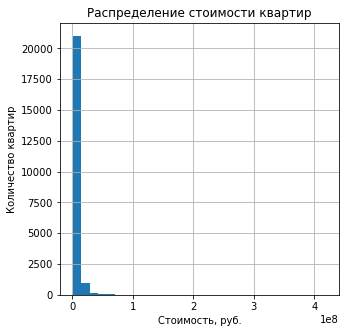

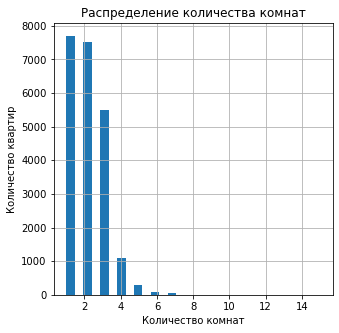

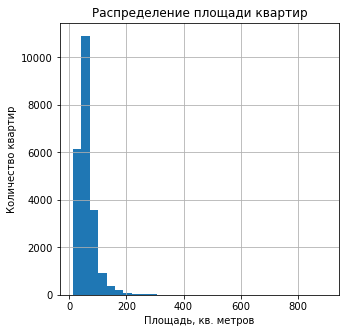

In [18]:
average_flat['last_price'].hist(figsize=(5,5), bins=30)

plt.title('Распределение стоимости квартир')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Количество квартир')
plt.show()

average_flat['rooms'].hist(figsize=(5,5), bins=30)

plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

average_flat['total_area'].hist(figsize=(5,5), bins=30)

plt.title('Распределение площади квартир')
plt.xlabel('Площадь, кв. метров')
plt.ylabel('Количество квартир')
plt.show()

Мало, что понятно с этих гистограмм общей площади и цены, аномально большие значения значительно на них повлияли. В случае гистограммы количества комнат, можно заметить, что абсолютное большинство значений приходится на однушки и двушки, чуть меньше на трёшки и ещё меньше на 4-х комнатные квартиры. Здесь так же присутствуют редкие значения количества комнат (>7).

Итак, стоимость квартиры колеблется с минимальной в 430 тысяч до максимальной в 420 миллионов.

Количество комнат колеблется с 1 до 15. Общая площадь с 12 до 900 квадратных метров.

Начнём "причёсывать" наши данные, начав с цены квартиры и диаграммы размаха.

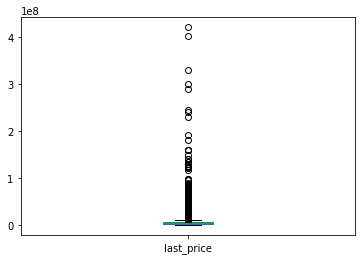

In [19]:
df.plot(kind='box', y='last_price')

plt.show()

Видно много выбросов, межквартильных размах сжался очень значительно.

Попробуем поставить верхнюю границу.

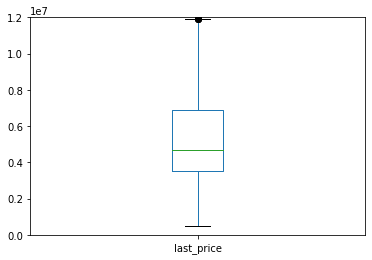

In [20]:
df.plot(kind='box', y='last_price', ylim=(0, 12000000))

plt.show()

Выглядить намного лучше.

Проверим, как будет выглядеть гистограмма распределения стоимости квартир с таким верхним пределом цены

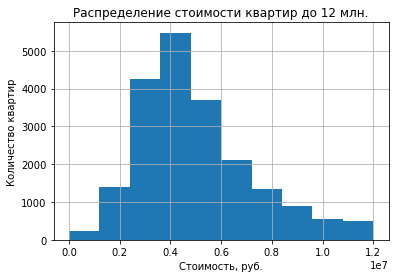

In [21]:
df['last_price'].hist(range=(0, 12000000))

plt.title('Распределение стоимости квартир до 12 млн.')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Количество квартир')

plt.show()

Уже напоминает привычную гистограмму.

Можем заметить, что на диаграмме размаха всё так же присутствуют выбросы. Чтобы разобраться с ними - удалим все экстремальные значения, которые привышают сумму третьего квартиля и полтора межкватрительного размаха. Применим этот метод ко всем трём столбцам.

In [22]:
df['last_price'].describe()['75%'] + 1.5*(df['last_price'].describe()['75%']-df['last_price'].describe()['25%'])

11928159.375

In [23]:
df['total_area'].describe()['75%'] + 1.5*(df['total_area'].describe()['75%']-df['total_area'].describe()['25%'])

114.85

In [24]:
df['rooms'].describe()['75%'] + 1.5*(df['rooms'].describe()['75%']-df['rooms'].describe()['25%'])

6.0

In [25]:
#Сделаем фильтр по стоимости квартиры, общей площади и количеству комнат и запишем подходящие строки в новый датафрейм good_df
good_df = df.query('last_price < 11986250')
good_df = good_df.query('20 < total_area < 115')
good_df = good_df.query('rooms < 6')

#посмотрим, как изменилась длина нашего датафрейма
print('Длина датафрейма до правок:', len(df))
print('Длина нового датафрейма после правок:', len(good_df))

Длина датафрейма до правок: 22268
Длина нового датафрейма после правок: 20184


Таким образом, наши данные стали беднее примерно на 10%. Но мы сделали благое дело, удалив аномальные значения.

Посмотрим, как изменилось описание нашего датафрейма good_df по сравнению с изначальным df

In [26]:
good_average_flat = good_df[['last_price', 'rooms', 'total_area']]
display(average_flat.describe())
good_average_flat.describe()

,last_price,rooms,total_area
count,2.226800e+04,22268.000000,22268.000000
mean,6.526920e+06,2.070684,60.039016
std,9.367044e+06,1.028466,33.186710
min,4.700000e+05,1.000000,12.000000
25%,3.500000e+06,1.000000,40.100000
50%,4.700000e+06,2.000000,52.000000
75%,6.871264e+06,3.000000,70.000000
max,4.200000e+08,15.000000,900.000000


,last_price,rooms,total_area
count,2.018400e+04,20184.000000,20184.000000
mean,4.916119e+06,1.923355,52.898538
std,2.173952e+06,0.868345,17.613110
min,4.700000e+05,1.000000,20.100000
25%,3.400000e+06,1.000000,39.000000
50%,4.500000e+06,2.000000,49.100000
75%,6.000000e+06,3.000000,63.100000
max,1.198388e+07,5.000000,114.800000


Среднее отклонение упало во всех столбцах, сильнее всего в столбце с ценой - почти в 4.5 раза. Средние значения по столбцам стали почти равны медианным, что тоже не может не радовать.

Гистограммы по отфильтрованным данным будут выглядеть так:

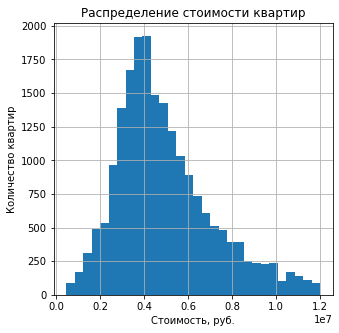

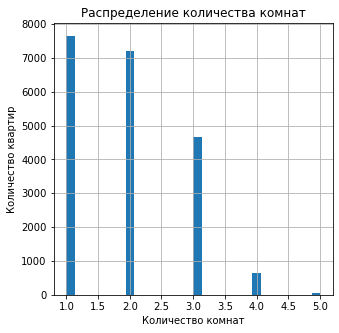

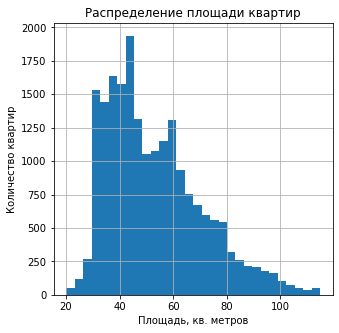

In [27]:
good_average_flat['last_price'].hist(figsize=(5,5), bins=30)
plt.title('Распределение стоимости квартир')
plt.xlabel('Стоимость, руб.')
plt.ylabel('Количество квартир')
plt.show()

good_average_flat['rooms'].hist(figsize=(5,5), bins=30)
plt.title('Распределение количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()

good_average_flat['total_area'].hist(figsize=(5,5), bins=30)
plt.title('Распределение площади квартир')
plt.xlabel('Площадь, кв. метров')
plt.ylabel('Количество квартир')
plt.show()

Такие гистограммы уже более правдоподобны. По ним можно сделать выводы.

#### Промежуточные выводы

Стоимость квартир всё так же довольно сильно отличается, но большинство объявлений находится в промежутке от 3 до 6 млн.

Большинство квартир являются однушками или двушками, трёшек меньше примерно в полтора раза. Всех остальных видов квартир уже значительно меньше.

Площадь квартир так же значительно различается. Больше всего значений находятся в интервале от 40 до 60 квадратных метров.

### Время продажи квартиры

In [28]:
descr_good = good_df['days_exposition'].describe() #сохраним в переменную описание количества дней размещения квартиры
descr_good

count    20184.000000
mean       166.668525
std        201.936637
min          1.000000
25%         45.000000
50%         92.000000
75%        200.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее очень большое, это не очень хорошо. Максимальное значение аномально большое. Среднее и медианное значение так же прилично отличаются. 

Посмотрим на гистограмму.

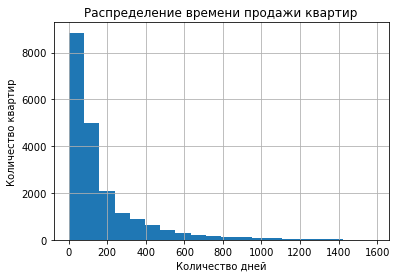

In [29]:
good_df['days_exposition'].hist(bins=20)

plt.title('Распределение времени продажи квартир')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')

plt.show()

Наблюдаем очень большой разброс значений, притом, что большинство их находится примерно до 160 дней.

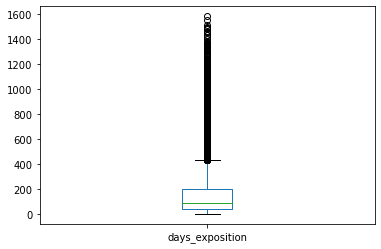

In [30]:
good_df.plot(kind='box', y='days_exposition')

plt.show()

Ящик с усами так же это подтверждает

Разберёмся с аномальными значениями таким же методом, как и в предыдущем пункте

In [31]:
good_df['days_exposition'].describe()['75%'] + 1.5*(good_df['days_exposition'].describe()['75%']-good_df['days_exposition'].describe()['25%'])

432.5

In [32]:
good_df = good_df.query('days_exposition < 430') 

In [33]:
display(descr_good) #необработанные значения
good_df['days_exposition'].describe() #обработанные

count    20184.000000
mean       166.668525
std        201.936637
min          1.000000
25%         45.000000
50%         92.000000
75%        200.000000
max       1580.000000
Name: days_exposition, dtype: float64

count    18266.000000
mean       113.261141
std         98.571160
min          1.000000
25%         44.000000
50%         83.000000
75%        154.000000
max        429.000000
Name: days_exposition, dtype: float64

Отклонение упало более чем в 2 раза, медианное и среднее значения почти сравнялись.

Теперь посмотрим, что будет на гистограмме.

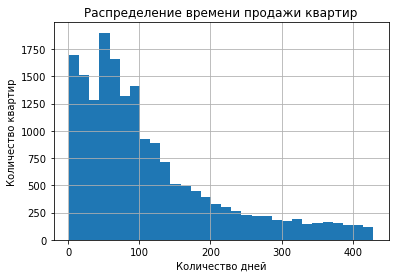

In [34]:
good_df['days_exposition'].hist(bins=30)

plt.title('Распределение времени продажи квартир')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')

plt.show()

Тут уже намного лучше всё видно. 

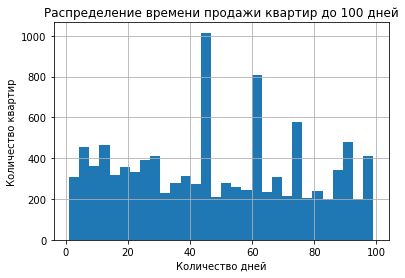

In [35]:
good_df.query('days_exposition < 100')['days_exposition'].hist(bins=30)

plt.title('Распределение времени продажи квартир до 100 дней')
plt.xlabel('Количество дней')
plt.ylabel('Количество квартир')

plt.show()

На гистограмме можем наблюдать заметные пики в районе 45, 60, 75 и 90 дней. Пики в 75 дней и 90 легко объясняются нашими медианными значениями, которые встали заместо пропусков. Пики же в 45 и 60 были в изначальных данных (я проверил). Возможно, 45 и 60 дней являются золотыми днями для продажи квартиры в Петербурге? Другого объяснения я пока не вижу.

#### Промежуточные выводы

В основном квартиры продаются от 45 до 150 дней. Меньше 45 дней - продажа быстрая, а больше 150 - долгая. При этом довольно большое количество объявления приходится на 45, 60 75 и 90 дней.

### Факторы, влияющие на стоимость

Построим матрицу корреляции для стоимости квартиры. Затем выделим параметры, которые сильнее всего влияют на неё.

In [36]:
good_df.corr()['last_price'].sort_values() #матрица корреляции, с выведением значений только по нужному нам параметру(стоимость)

city_centers_nearest   -0.392021
kitchen_total_ratio    -0.134646
ponds_nearest          -0.051787
airports_nearest       -0.036960
is_studio              -0.024029
weekday                -0.011854
has_open_plan          -0.002520
month                   0.003931
living_total_ratio      0.014397
is_apartment            0.019455
floor_grouped           0.034001
days_exposition         0.036443
parks_nearest           0.039877
year                    0.043442
balcony                 0.071064
parks_around_3000       0.106893
floor                   0.132308
ponds_around_3000       0.140078
total_images            0.173659
floors_total            0.195282
ceiling_height          0.403040
rooms                   0.443773
kitchen_area            0.465817
living_area             0.563477
square_meter_price      0.621767
total_area              0.708584
last_price              1.000000
Name: last_price, dtype: float64

Матрица корреляции применительно к нашему исследуемому параметру (общей стоимости квартиры) даёт такие результаты:

Из всех параметров наибольшее влияние на стоимость квартиры оказывают такие факторы, как общая площадь, стоимость квадратного метра, жилая площадь. В меньшей степени оказывают влияние площадь кухни, количество комнат и высота потолков, а также расстояние до центра Санкт-Петербурга. Все остальные параметры практически не оказывают никакого влияния.

Теперь строим матрицу рассеяния по самым значимым параметрам.

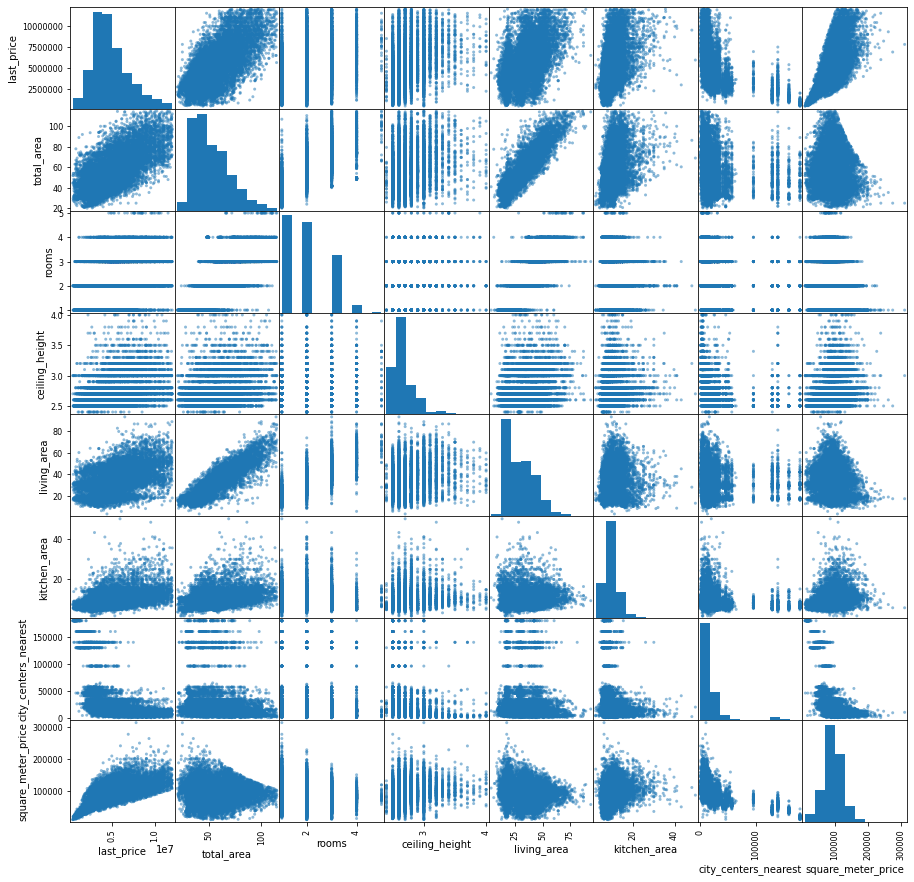

In [37]:
factors = good_df[
    ['last_price', 'total_area', 'rooms', 'ceiling_height' , 'living_area', 'kitchen_area', 'city_centers_nearest', 'square_meter_price']]
pd.plotting.scatter_matrix(factors, figsize=(15,15))
plt.show()

#### Промежуточные выводы

Матрица диаграмм рессеяния даёт нам такие результаты:

1. Наблюдается достаточно сильная положительная зависимость между стоимостью и общей площадью квартиры, ценой одного квадратного метра. С увеличением одной величины начинает расти и вторая.

2. В сегменте дорогих квартир (с 8 миллионов) меньше однокомнатных квартир, а в сегменте недорогих квартир (до 4 миллионов) меньше квартир с 4-мя комнатами. И это очень логично. Помимо этого, в случае квартир до 3 комнат, есть чёткая зависимость от стоимости квартиры. Стоимость же многоквартирных квартир уже довольно непредсказуема. 

3. Можно наблюдать устойчивую связь между стоимостью квартир от 4 до 8 млн. и жилой площадью до 50 кв.м. Кроме того, мы можем наблюдать очень большой разброс стоимости квартир площадью более 50 кв.м. - стоимость может быть как меньше 5 млн., так и более 10 млн. То есть в случае квартир площадью более 50 кв.м. зависимость стоимости от площади квартиры является неравномерной.

4. Наблюдается устойчивая связь между стоимостью квартиры и площадью кухни до 15 кв.м. В квартирах с кухней более 15 кв.м. стоимость распределена достаточно неравномерно.

5. Явная зависимость наблюдается между стоимостью и высотой потолков от 2.5 до 3.2 метров. 

6. Между стоимостью и расстоянием до центра можно заметить отрицательную связь. Наиболее явно она прослеживается до 10 км.

### 10 Населённых пунктов

In [38]:
localities_list = good_df['locality_name'].value_counts().to_list() #для дальнейшего сравнения 

#сохраним в словаре отсортированные по частоте появления названия населённых пунктов
#(название населенного пункта : число появлений)
localities_dict = good_df['locality_name'].value_counts().to_dict()
localities_dict

#теперь создаём пустой список, в который с помощью цикла будем добавлять все населенные пункты, которые появляются чаще 3 раз
#это необходимо, чтобы при дальнейшей работе не сделать общих выводов, основываясь на малом количестве объявлений
good_local_list = []
for k,v in localities_dict.items():
    if v > 15:
        good_local_list.append(k)
        
print(len(localities_list))        
len(good_local_list)  

216


52

Число населённых пунктов уменьшилось - значит всё работает.

Теперь сохраним в новом датафрейме localities_df все строки, в которых населённый пункт входит в наш отфильтрованный список

In [39]:
localities_df = good_df[good_df['locality_name'].isin(good_local_list)]
localities_square_meter = (
    localities_df
    .pivot_table(index=['locality_name'], values='square_meter_price', aggfunc=['median', 'count'])
    )

localities_square_meter.columns=['square_meter_price', 'count']
localities_square_meter = localities_square_meter.sort_values(by='square_meter_price', ascending=False).head(10)

display(localities_square_meter.loc[:'Кудрово']) #топ 5 с начала
localities_square_meter.loc['поселок Парголово':'Петергоф'] #топ 5 с конца

,square_meter_price,count
locality_name,,
Санкт-Петербург,102142.9,12151
Сестрорецк,100985.5,135
Зеленогорск,100000.0,17
Пушкин,98482.6,302
Кудрово,96052.6,395


,square_meter_price,count
locality_name,,
поселок Парголово,92097.10,274
поселок Стрельна,87323.35,30
Мурино,86268.90,477
Павловск,86244.25,30
Петергоф,82474.20,167


#### Промежуточные выводы

Мы выделили 10 населённых пунктов с наибольшей стоимостью квадратного метра. Разбили их на две пятёрки.

Самым дорогим (сюрприз) оказался Петербург.

### Квартиры в Петербурге

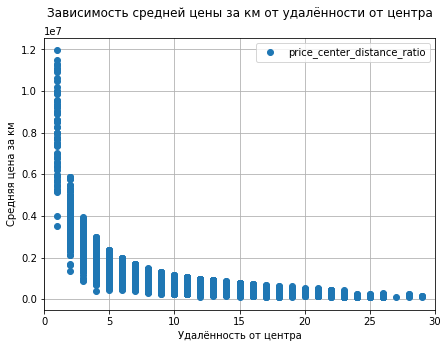

In [40]:
flats_spb = good_df.query('locality_name == "Санкт-Петербург"') #выделяем квартиры в Петербурге

#переводим метры в километры, меняя сам столбец, округляем значение
flats_spb['city_centers_nearest'] = (flats_spb['city_centers_nearest'] / 1000).round(0)

#добавляем столбец со средней ценой для каждого километра
flats_spb['price_center_distance_ratio'] = flats_spb['last_price'] / flats_spb['city_centers_nearest'] 

#строим график зависимости средней цены за км от удалённости от центра
flats_spb.plot(x='city_centers_nearest', y='price_center_distance_ratio', grid=True, style='o', xlim=(0,30), figsize=(7,5))
plt.title('Зависимость средней цены за км от удалённости от центра' + "\n")
plt.xlabel('Удалённость от центра')
plt.ylabel('Средняя цена за км')
plt.show()

График даёт нам понять, что центр города находится в пределах 4 км. Так как здесь наблюдается наиболее резкое падение средней цены за км.

Теперь посмотрим корряляцию по стоимости квартиры в центре

In [41]:
flats_spb.corr()['last_price'].sort_values()

city_centers_nearest          -0.342813
kitchen_total_ratio           -0.169957
ponds_nearest                 -0.067112
is_studio                     -0.018709
airports_nearest              -0.011487
weekday                       -0.007339
has_open_plan                 -0.004001
month                         -0.002166
is_apartment                   0.005814
parks_nearest                  0.030385
living_total_ratio             0.033052
floor_grouped                  0.057165
year                           0.068261
floor                          0.072942
balcony                        0.076060
days_exposition                0.090139
floors_total                   0.100213
parks_around_3000              0.112756
total_images                   0.157774
ponds_around_3000              0.167465
ceiling_height                 0.392827
square_meter_price             0.426369
rooms                          0.496928
kitchen_area                   0.506496
price_center_distance_ratio    0.513077


#### Промежуточные выводы

Матрица корреляции по стоимости квартиры даёт такие результаты:

Наибольшее влияние на стоимость оказывают общая площадь квартиры, жилая площадь и площадь кухни, средняя цена за километр от центра. В меньшей степени влияют количество комнат, высота потолков, цена квадратного метра, а также расстояние до центра.

### Квартиры в центре Петербурга

In [42]:
flats_spb_center = flats_spb.query('city_centers_nearest < 4') #фильтр для центральных квартир Петербурга
flats_not_spb = good_df.query('locality_name != "Санкт-Петербург"') #фильтр для квартир вне Петербурга

#хитрые операции по созданию датафрейма и слиянию двух таблиц, внутри которых значения корреляции по параметру стоимости квартиры
#в конечном итоге у нас получится 3 столбца, в которых будут коррялции по параметру стоимости в зависимости от местоположения квартиры
corr_df = (
    pd.DataFrame(flats_spb_center.corr()['last_price'])
    .join(pd.DataFrame(flats_spb.corr()['last_price']),
    lsuffix='_Центр Петербурга', rsuffix='_Петербург')
)

corr_df = corr_df.join(pd.DataFrame(flats_not_spb.corr()['last_price']))
corr_df.columns = ['Центр Петербурга', 'Петербург', 'Область'] #для удобства переименум столбцы

corr_df.sort_values(by='Область') #и отсортируем значения по одному столбцу

,Центр Петербурга,Петербург,Область
city_centers_nearest,-0.165117,-0.342813,-0.419212
kitchen_total_ratio,-0.164611,-0.169957,-0.063078
living_total_ratio,0.099242,0.033052,-0.054628
ponds_nearest,-0.034979,-0.067112,-0.026096
is_studio,NaN,-0.018709,-0.023616
weekday,0.009611,-0.007339,-0.021906
parks_nearest,0.014880,0.030385,-0.014321
month,-0.085751,-0.002166,0.000125
has_open_plan,-0.051616,-0.004001,0.003700
year,0.110862,0.068261,0.011931


Выводы по таблице с корреляцией по стоимости оставлю в общих выводах.

## Общий вывод

Наша таблица с корреляцией по стоимости квартиры в зависимости от местоположения даёт такие результаты:

* Наблюдается сильная положительная корреляция между общей площадью и стоимостью квартиры (от 6.4 до 7.9). Возможное объяснение кроется в третьем факторе - жилой площади. С увеличением общей площади увеличивается и жилая площадь, что положительно сказывается на стоимости.

* Большое влияние на стоимость квартиры в области оказывает стоимость квадратного метра (6.3). Меньшее значение в Петербурге (4.2), а в центре ещё ниже (2.7). 

* В центральных квартирах Петербурга площадь кухни влияет меньше на стоимость (3.1), чем в среднем по Петербургу (5) и за его пределами (4.8). В области и в общем по Петербургу зависимость цены от размера кухни примерна на одном уровне.

* Количество комнат больше всего влияет на стоимость квартир в Петербурге (5) и его центре (5.1). В области эта зависимоть ниже (3.9).

* Высота потолков оказывает наибольшее значение на стоимость квартир в Петербурге (3.1). Меньше - в Центре Петербурга (1.6) и ещё меньше в Области (1.1).

* В Области наблюдается небольшая положительная зависимость стоимости квартиры от количества этажей дома (2.5).

* Так же, можно проверить себя на очевидность: коэффициент корреляции становится более отрицательным с увеличением расстояния от центра (-1.7 >>> -3.4 >>> -4.2), при этом цена квартир становится меньше дальше от центра. Всё логично.